In [2]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from PIL import Image
import io

In [3]:
# classifier = r"C:\Users\tobia\Nextcloud\Shared\SKA_MPG_Tests\RF_Poinint\rfi_flagging\KuBandClassifier.pkl"
path = "/content/drive/MyDrive/data/tagging_db.sqlite"

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:

def get_rows(select_sql = "SELECT * FROM observation_tagging LEFT OUTER JOIN rows ON observation_tagging.obs_id = rows.obs_id;",
                    sqlite_file = None):
    if not sqlite_file:
        sqlite_file = path

    cols = 'obs_id fname image tags obs_id2 row_json'.split()

    try:
        con = sqlite3.connect(sqlite_file)

        with con:
            cursor = con.cursor()
            cursor.execute(select_sql)
            rows = cursor.fetchall()
            rows = [dict(zip(cols, i)) for i in rows]
            cursor.close()
            return rows

    finally:
        if 'con' in locals() and con:
            con.close()

In [6]:
rows = get_rows()
for i in range(len(rows)):
    rows[i]['image'] = np.array(Image.open(io.BytesIO(rows[i]['image'])), dtype=np.uint8)

In [7]:
rows[0].keys()

dict_keys(['obs_id', 'fname', 'image', 'tags', 'obs_id2', 'row_json'])

___
# TRAIN CLF
___

In [8]:
from sklearn.model_selection import train_test_split

In [18]:
import keras
from keras import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, LeakyReLU
# from keras.layers.advanced_activations import

from keras.utils import to_categorical

# Make DataSet

In [74]:
X = np.array([r['image'] for r in rows])
X.shape

(1161, 100, 100)

In [75]:
y = np.array([1 if not 'bad' in r['tags'] else 0 for r in rows])
y.shape, np.sum(y) / len(y)

((1161,), 0.3875968992248062)

In [76]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33, random_state=42)

In [77]:
train_X.shape

(777, 100, 100)

In [78]:

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (777, 100, 100) (777,)
Testing data shape :  (384, 100, 100) (384,)


In [79]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [80]:
n_samples, n, m = X.shape
train_X = train_X.reshape(-1, n, m, 1)
test_X = test_X.reshape(-1, n, m, 1)
test_Y = test_Y.reshape(-1, 1)
train_Y = train_Y.reshape(-1, 1)

train_X.shape, test_X.shape, test_Y.shape, train_Y.shape


((777, 100, 100, 1), (384, 100, 100, 1), (384, 1), (777, 1))

In [81]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.


# Make Model

In [84]:
batch_size = 64
epochs = 20

In [90]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(n,m,1),padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(1, activation='sigmoid'))


In [91]:
cnn_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [92]:
cnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                

In [93]:
train_X.shape, train_Y.shape

((777, 100, 100, 1), (777, 1))

In [94]:
cnn_train = cnn_model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_X, test_Y))


Epoch 1/20
13/13 [==============================] - 21s 2s/step - loss: 0.5317 - accuracy: 0.7117 - val_loss: 0.4277 - val_accuracy: 0.8151
Epoch 2/20
13/13 [==============================] - 19s 1s/step - loss: 0.3469 - accuracy: 0.8468 - val_loss: 0.3328 - val_accuracy: 0.8438
Epoch 3/20
13/13 [==============================] - 23s 2s/step - loss: 0.2837 - accuracy: 0.8777 - val_loss: 0.3397 - val_accuracy: 0.8464
Epoch 4/20
13/13 [==============================] - 19s 2s/step - loss: 0.2655 - accuracy: 0.8803 - val_loss: 0.3109 - val_accuracy: 0.8385
Epoch 5/20
13/13 [==============================] - 19s 2s/step - loss: 0.2577 - accuracy: 0.8829 - val_loss: 0.2915 - val_accuracy: 0.8646
Epoch 6/20
13/13 [==============================] - 21s 2s/step - loss: 0.2209 - accuracy: 0.8945 - val_loss: 0.2813 - val_accuracy: 0.8672
Epoch 7/20
13/13 [==============================] - 19s 2s/step - loss: 0.2073 - accuracy: 0.9035 - val_loss: 0.2601 - val_accuracy: 0.8984
Epoch 8/20
13/13 [==

In [95]:
test_eval = cnn_model.evaluate(test_X, test_Y, verbose=0)


In [96]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.3192974030971527
Test accuracy: 0.9036458134651184


In [101]:
cnn_train.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

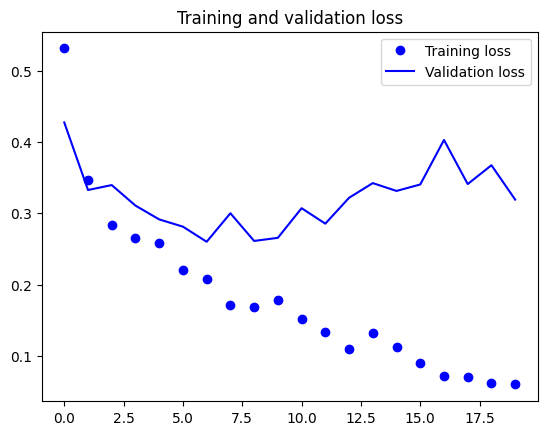

In [102]:
accuracy = cnn_train.history['accuracy']
val_accuracy = cnn_train.history['val_accuracy']
loss = cnn_train.history['loss']
val_loss = cnn_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [113]:
cnn_model.save("/content/drive/MyDrive/data/20231011_cnn_model.keras")

In [114]:
image = rows[0]['image']

In [125]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/data/20231011_cnn_model.keras")

In [126]:
def predict(image):
    n, m = image.shape
    x = image.reshape(1, n, m, 1)
    x = x.astype(float) / 255.
    pc = reconstructed_model.predict(x, verbose = 0)
    return int(np.round(pc[0]))

In [127]:
predict(rows[0]['image']), rows[0]['tags']

(1, 'good')

In [135]:
predicted_classes = cnn_model.predict(test_X)
predicted_classes = np.round(predicted_classes).astype(int)


12/12 [==============================] - 2s 159ms/step


In [136]:
predicted_classes.shape, test_Y.shape

((384, 1), (384, 1))

Found 347 correct labels


<ipython-input-137-dbee0304efa6>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


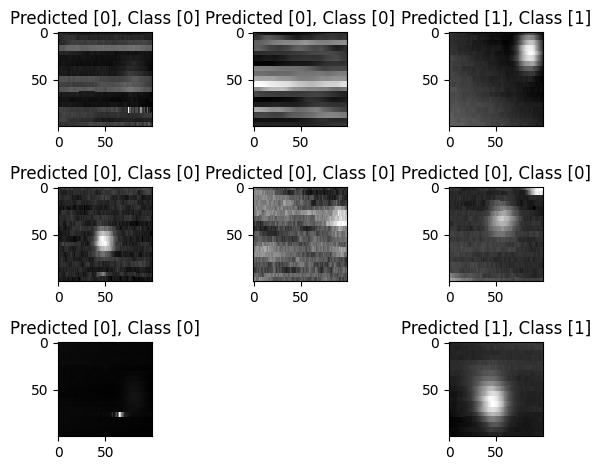

In [137]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found {} correct labels".format(len(correct)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(n,m), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()


Found 37 incorrect labels


<ipython-input-138-a322eb86070a>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


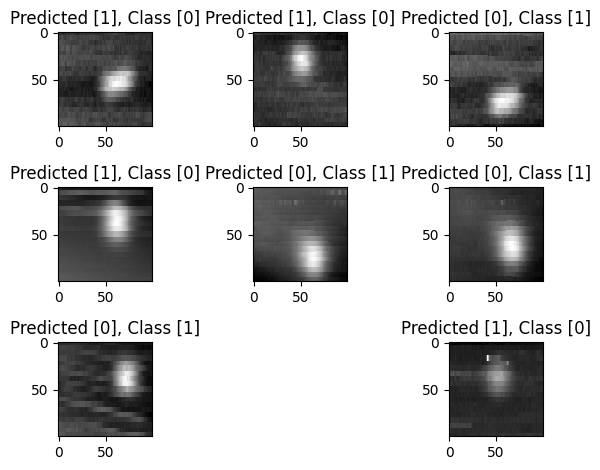

In [138]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found {} incorrect labels".format(len(incorrect)))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(n,m), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()


In [139]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))


              precision    recall  f1-score   support

     Class 0       0.91      0.92      0.92       225
     Class 1       0.89      0.87      0.88       159

    accuracy                           0.90       384
   macro avg       0.90      0.90      0.90       384
weighted avg       0.90      0.90      0.90       384

